In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.animation as animation
import time as TIME
import math
import re
import random

In [2]:
# 10部件                         1 2 3 4 5 6 7 8 9 10
prior_constrain_p10 = np.array([[0,1,1,1,1,0,0,0,0,0], # 1
                                [0,0,0,0,0,1,0,0,0,0], # 2
                                [0,0,0,0,0,0,0,0,0,0], # 3
                                [0,0,0,0,0,0,1,0,0,0], # 4
                                [0,0,0,0,0,0,0,0,0,0], # 5
                                [0,0,0,0,0,0,0,1,0,0], # 6
                                [0,0,0,0,0,0,0,0,1,0], # 7
                                [0,0,0,0,0,0,0,0,0,0], # 8
                                [0,0,0,0,0,0,0,0,0,1], # 9
                                [0,0,0,0,0,0,0,0,0,0]])# 10
num_of_part_p10 = 10
CT_p10 = 26
time_p10 = np.array([3, 8, 6, 10, 9, 6, 7, 7, 10, 7])
danger_p10 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0])
need_p10 = np.array([0, 500, 0, 0, 0, 750, 295, 0, 360, 0])
disassembly_side_p10 = np.array([1, -1, 1, 1, 1, 1, 0, 1, -1, 0]) # 1左边，-1右边，0两边都可以
relate_p10 = np.zeros(shape=(num_of_part_p10, num_of_part_p10))
revenue_p10 = np.array([20.03, 30.12, 30.25, 20.52, 30.65, 20.51, 10.75, 50.80, 30.46, 30.60])
c_p10 = 0.35

In [3]:
class get_candid:
    def __init__(self, prior_constrain, disassembly_side):
        self.prior_constrain = copy.deepcopy(prior_constrain)
        self.disassembly_side = disassembly_side
        
    def get_can_do_task(self, did_tasks):
        did_tasks_with0_encoding = [abs(ele)-1 for ele in did_tasks]
        self.prior_constrain[did_tasks_with0_encoding, :] = 0
        can_do_tasks = np.argwhere(np.sum(self.prior_constrain, axis=0)==0).reshape(-1).tolist()
        for did_task in did_tasks_with0_encoding:
            can_do_tasks.remove(did_task)
        can_do_tasks = (np.array(can_do_tasks) + 1).tolist()
        can_do_tasks_duplic = copy.deepcopy(can_do_tasks)
        for ele in can_do_tasks_duplic:
            if self.disassembly_side[ele-1] == -1:
                can_do_tasks.remove(ele)
                can_do_tasks.append(-1*ele)
            elif self.disassembly_side[ele-1] == 0:
                can_do_tasks.append(-1*ele)
        return can_do_tasks

In [4]:
def init_pop_rondom_method(num_of_part_p, prior_constrain_p, disassembly_side_p, num_of_pop):
    num_of_part = num_of_part_p
    prior_constrain = prior_constrain_p
    disassembly_side = disassembly_side_p
    pops = []
    for _ in range(num_of_pop):
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        for _ in range(num_of_part):
            candid_task = candidate.get_can_do_task(pop)
            choiced_task = np.random.choice(candid_task)
            pop.append(choiced_task)
        pops.append(pop)
    return np.array(pops)

In [5]:
def check(individual, prior_constrain_p, disassembly_side_p):
    pop = individual
    prior_constrain = copy.deepcopy(prior_constrain_p)
    disassembly_side = disassembly_side_p

    for part in pop:
        if np.sum(prior_constrain, axis=0)[abs(part)-1] != 0:
            return False
        else:
            prior_constrain[abs(part)-1,:] = 0
        if disassembly_side[abs(part)-1] == 1 and part < 0:
            return False
        elif disassembly_side[abs(part)-1] == -1 and part > 0:
            return False
    return True

In [6]:
def softmax(f):
    f -= np.max(f)
    return np.exp(f) / np.sum(np.exp(f))
# ****************************************************************
def getChoiceProb(branchInfo, visitNumInfo, visitNumOfParent, temp, p):
    alpha_Hb = (visitNumInfo+0.000000000001)/(visitNumOfParent + 0.000000001)
    alpha_Hb = np.min(np.concatenate((alpha_Hb[np.newaxis,...], 
                                      np.ones(alpha_Hb.shape)[np.newaxis,...])), axis=0)
    beta_Hb = (visitNumInfo+0.000000000001)/(branchInfo + 0.000000001)
    beta_Hb = np.min(np.concatenate((beta_Hb[np.newaxis,...],
                                      np.ones(beta_Hb.shape)[np.newaxis,...])), axis=0)
    if np.random.uniform() >= p:
        logits = -1*np.log(beta_Hb)
    else:
        logits = -1*np.log(alpha_Hb)
    prob = softmax(logits/temp)
    return prob

# 使用字典

In [7]:
def init(num_ele, pop_num, temperature, prior_constrain, disassembly_side):
    global memory_visit
    global memory_branch
    memory_visit = dict()
    memory_branch = dict()
    pops = []
    last_unique_num = len(pops)
    while len(pops)<pop_num:
        pop = []
        candidate = get_candid(prior_constrain, disassembly_side)
        candid_nodes = candidate.get_can_do_task(pop)
        candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        
        while len(pop) < num_ele: 
            layer = len(pop)
            if layer == 0:
                candid_chain = [pop+[ele-num_ele] for ele in candid_nodes]
                condid_brance_info = []
                condid_visit_info = []
                for candid_chain_ele in candid_chain:
                    candid_dic_key = ''.join(str(candid_chain_ele_ele) 
                                               for candid_chain_ele_ele in candid_chain_ele)
                    if memory_branch.get(candid_dic_key) != None:
                        condid_brance_info.append(memory_branch[candid_dic_key])
                    else:
                        condid_brance_info.append(0)
                    
                    if memory_visit.get(candid_dic_key) != None:
                        condid_visit_info.append(memory_visit[candid_dic_key])
                    else:
                        condid_visit_info.append(0)
                condid_brance_info = np.array(condid_brance_info)
                condid_visit_info = np.array(condid_visit_info)
                
                parent_visit_info = []
                for candid_nodes_ele in candid_nodes:
                    parent_dic_key = str(candid_nodes_ele-num_ele)
                    if memory_visit.get(parent_dic_key) != None:
                        parent_visit_info.append(memory_visit[parent_dic_key])
                    else:
                        parent_visit_info.append(0)
                parent_visit_info = np.sum(parent_visit_info)

                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)
                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                pop.append(choiced_node-num_ele)
            

            else:
                candid_chain = [pop+[ele-num_ele] for ele in candid_nodes]

                condid_brance_info = []
                condid_visit_info = []
                for candid_chain_ele in candid_chain:
                    candid_dic_key = ''.join(str(candid_chain_ele_ele) 
                                               for candid_chain_ele_ele in candid_chain_ele)
                    if memory_branch.get(candid_dic_key) != None:
                        condid_brance_info.append(memory_branch[candid_dic_key])
                    else:
                        condid_brance_info.append(0)
                    
                    if memory_visit.get(candid_dic_key) != None:
                        condid_visit_info.append(memory_visit[candid_dic_key])
                    else:
                        condid_visit_info.append(0)
                condid_brance_info = np.array(condid_brance_info)
                condid_visit_info = np.array(condid_visit_info)

                parent_dic_key = ''.join(str(pop_ele) for pop_ele in pop)
                parent_visit_info = memory_visit[parent_dic_key]
                
                
                choice_prob = getChoiceProb(condid_brance_info, condid_visit_info, parent_visit_info, 
                                            temperature, 1-len(pops)/pop_num)
                choiced_node = np.random.choice(candid_nodes, p=choice_prob)
                
                pop.append(choiced_node-num_ele)
            
            dic_key = ''.join(str(pop_ele) for pop_ele in pop)
            if memory_visit.get(dic_key) != None:
                memory_visit[dic_key] += 1
            else:
                memory_visit[dic_key] = 1
            
            
            candid_nodes = candidate.get_can_do_task(pop)
            flag = 0
            candid_nodes = (np.array(candid_nodes)+num_ele).tolist()
        pops.append(pop)

        if memory_visit.get(dic_key) == 1:
            for index_unique_pop in range(len(pop)):
                branch_key = ''.join(str(unique_pop_ele) for unique_pop_ele in pop[:index_unique_pop+1])
                if memory_branch.get(branch_key) != None:
                    memory_branch[branch_key] += 1
                else:
                    memory_branch[branch_key] = 1
    return np.array(pops)

### 常规初始化1000个个体

In [22]:
start_time = TIME.time()
pops = init(num_ele=num_of_part_p10, pop_num=1000, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
print(TIME.time() - start_time)

0.950308084487915


In [23]:
for pop_ in pops:
    for i in range(len(pop_)):
        key_chain = ''.join(str(pop_ele) for pop_ele in pop_[:i+1])
        print(key_chain)
        print('分支数：',memory_branch[key_chain])
        print('访问数：',memory_visit[key_chain])
        print('有效访问率为：{}%'.format(100*memory_branch[key_chain]/memory_visit[key_chain]))
        print()
    print('*'*90)

1
分支数： 941
访问数： 1000
有效访问率为：94.1%

1-2
分支数： 264
访问数： 270
有效访问率为：97.77777777777777%

1-25
分支数： 62
访问数： 63
有效访问率为：98.41269841269842%

1-256
分支数： 25
访问数： 26
有效访问率为：96.15384615384616%

1-2564
分支数： 10
访问数： 10
有效访问率为：100.0%

1-2564-7
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2564-7-9
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2564-7-93
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2564-7-938
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2564-7-938-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

153-2
分支数： 31
访问数： 44
有效访问率为：70.45454545454545%

153-26
分支数： 13
访问数： 23
有效访问率为：56.52173913043478%

153-264
分支数： 9
访问数： 10
有效访问率为：90.0%

153-264-7
分支数： 3
访问数： 4
有效访问率为：75.0%

153-264-7-9
分支数： 1
访问数： 1
有效访问率为：100.0%

153-264-7-98
分支数： 1
访问数： 1
有效访问率为：100.0%

153-264-7-9810
分支数： 1
访问数： 1
有效访问率为：100.0%

*****************************************************

访问数： 3
有效访问率为：100.0%

147-9103
分支数： 1
访问数： 1
有效访问率为：100.0%

147-91035
分支数： 1
访问数： 1
有效访问率为：100.0%

147-91035-2
分支数： 1
访问数： 1
有效访问率为：100.0%

147-91035-26
分支数： 1
访问数： 1
有效访问率为：100.0%

147-91035-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

135
分支数： 62
访问数： 77
有效访问率为：80.51948051948052%

135-2
分支数： 33
访问数： 43
有效访问率为：76.74418604651163%

135-26
分支数： 13
访问数： 20
有效访问率为：65.0%

135-264
分支数： 9
访问数： 10
有效访问率为：90.0%

135-2648
分支数： 4
访问数： 5
有效访问率为：80.0%

135-2648-7
分支数： 2
访问数： 2
有效访问率为：100.0%

135-2648-7-9
分支数： 2
访问数： 2
有效访问率为：100.0%

135-2648-7-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

135
分支数： 62
访问数： 77
有效访问率为：80.51948051948052%

135-2
分支数： 33
访问数： 43
有效访问率为：76.74418604651163%


有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

135
分支数： 62
访问数： 77
有效访问率为：80.51948051948052%

135-2
分支数： 33
访问数： 43
有效访问率为：76.74418604651163%

135-26
分支数： 13
访问数： 20
有效访问率为：65.0%

135-264
分支数： 9
访问数： 10
有效访问率为：90.0%

135-264-7
分支数： 2
访问数： 2
有效访问率为：100.0%

135-264-7-9
分支数： 1
访问数： 1
有效访问率为：100.0%

135-264-7-98
分支数： 1
访问数： 1
有效访问率为：100.0%

135-264-7-9810
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

1-2
分支数： 264
访问数： 270
有效访问率为：97.77777777777777%

1-25
分支数： 62
访问数： 63
有效访问率为：98.41269841269842%

1-254
分支数： 19
访问数： 19
有效访问率为：100.0%

1-2546
分支数： 4
访问数： 4
有效访问率为：100.0%

1-25467
分支数： 1
访问数： 1
有效访问率为：100.0%

1-254678
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2546783
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2546783-9
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2546783-9-10
分支数： 1
访问数

有效访问率为：94.38202247191012%

13-26
分支数： 24
访问数： 28
有效访问率为：85.71428571428571%

13-265
分支数： 9
访问数： 12
有效访问率为：75.0%

13-2654
分支数： 5
访问数： 5
有效访问率为：100.0%

13-26548
分支数： 2
访问数： 2
有效访问率为：100.0%

13-26548-7
分支数： 1
访问数： 1
有效访问率为：100.0%

13-26548-7-9
分支数： 1
访问数： 1
有效访问率为：100.0%

13-26548-7-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

1345
分支数： 16
访问数： 17
有效访问率为：94.11764705882354%

13457
分支数： 4
访问数： 5
有效访问率为：80.0%

13457-9
分支数： 3
访问数： 4
有效访问率为：75.0%

13457-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

13457-9-10-2
分支数： 1
访问数： 1
有效访问率为：100.0%

13457-9-10-26
分支数： 1
访问数： 1
有效访问率为：100.0%

13457-9-10-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

13-2
分

分支数： 3
访问数： 3
有效访问率为：100.0%

15-23476-9
分支数： 1
访问数： 1
有效访问率为：100.0%

15-23476-910
分支数： 1
访问数： 1
有效访问率为：100.0%

15-23476-9108
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

153-2
分支数： 31
访问数： 44
有效访问率为：70.45454545454545%

153-24
分支数： 18
访问数： 21
有效访问率为：85.71428571428571%

153-246
分支数： 6
访问数： 6
有效访问率为：100.0%

153-2468
分支数： 3
访问数： 3
有效访问率为：100.0%

153-24687
分支数： 2
访问数： 2
有效访问率为：100.0%

153-24687-9
分支数： 2
访问数： 2
有效访问率为：100.0%

153-24687-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

14-2
分支数： 47
访问数： 47
有效访问率为：100.0%

14-26
分支数： 11
访问数： 11
有效访问率为：100.0%

14-263
分支数： 1
访问数： 1
有效访问率为：100.0%

14-2637
分支数： 1
访问数： 1
有效访问率为：100.0%

14-2637-9
分支数： 1
访问

1-2456
分支数： 3
访问数： 3
有效访问率为：100.0%

1-2456-7
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2456-78
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2456-78-9
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2456-78-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

1-2456-78-9-103
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

1534
分支数： 30
访问数： 35
有效访问率为：85.71428571428571%

1534-7
分支数： 7
访问数： 9
有效访问率为：77.77777777777777%

1534-7-9
分支数： 3
访问数： 5
有效访问率为：60.0%

1534-7-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

1534-7-9-10-2
分支数： 1
访问数： 1
有效访问率为：100.0%

1534-7-9-10-26
分支数： 1
访问数： 1
有效访问率为：100.0%

1534-7-9-10-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

143
分支数： 43
访问数： 43
有效访问率为：100.0%

143-2
分支数： 16
访问数： 16
有效访问率为：100.

访问数： 20
有效访问率为：65.0%

135-268
分支数： 4
访问数： 10
有效访问率为：40.0%

135-2684
分支数： 4
访问数： 10
有效访问率为：40.0%

135-2684-7
分支数： 2
访问数： 4
有效访问率为：50.0%

135-2684-7-9
分支数： 2
访问数： 4
有效访问率为：50.0%

135-2684-7-910
分支数： 1
访问数： 2
有效访问率为：50.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

154
分支数： 75
访问数： 75
有效访问率为：100.0%

154-2
分支数： 21
访问数： 21
有效访问率为：100.0%

154-26
分支数： 6
访问数： 6
有效访问率为：100.0%

154-26-7
分支数： 2
访问数： 2
有效访问率为：100.0%

154-26-73
分支数： 1
访问数： 1
有效访问率为：100.0%

154-26-738
分支数： 1
访问数： 1
有效访问率为：100.0%

154-26-738-9
分支数： 1
访问数： 1
有效访问率为：100.0%

154-26-738-910
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

1-2
分支数： 264
访问数： 270
有效访问率为：97.77777777777777%

1-24
分支数： 82
访问数： 82
有效访问率为：100.0%

1-24-7
分支数： 11
访问数： 11
有效访问率为：100.0%

1-24-7-9
分支数： 5
访问数： 5
有效访问率为：100.0%

1-24-7-9

分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

15-2
分支数： 75
访问数： 87
有效访问率为：86.20689655172414%

15-26
分支数： 22
访问数： 28
有效访问率为：78.57142857142857%

15-264
分支数： 9
访问数： 9
有效访问率为：100.0%

15-2643
分支数： 3
访问数： 3
有效访问率为：100.0%

15-26438
分支数： 1
访问数： 1
有效访问率为：100.0%

15-26438-7
分支数： 1
访问数： 1
有效访问率为：100.0%

15-26438-7-9
分支数： 1
访问数： 1
有效访问率为：100.0%

15-26438-7-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

13-2
分支数： 84
访问数： 89
有效访问率为：94.38202247191012%

13-24
分支数： 37
访问数： 37
有效访问率为：100.0%

13-245
分支数： 13
访问数： 13
有效访问率为：100.0%

13-245-7
分支数： 3
访问数： 3
有效访问率为：100.0%

13-245-76
分支数： 2
访问数： 2
有效访问率为：100.0%

13-245-76-9
分支数： 1
访问数： 1
有效访问率为：100.0%

13-245-76-910
分支数： 1
访问数： 1
有效访问率为：100.0%

13-245-76-9108
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：

访问数： 2
有效访问率为：50.0%

134-75-910-268
分支数： 1
访问数： 2
有效访问率为：50.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

1534
分支数： 30
访问数： 35
有效访问率为：85.71428571428571%

1534-7
分支数： 7
访问数： 9
有效访问率为：77.77777777777777%

1534-7-2
分支数： 4
访问数： 4
有效访问率为：100.0%

1534-7-2-9
分支数： 2
访问数： 2
有效访问率为：100.0%

1534-7-2-910
分支数： 1
访问数： 1
有效访问率为：100.0%

1534-7-2-9106
分支数： 1
访问数： 1
有效访问率为：100.0%

1534-7-2-91068
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

14-7
分支数： 49
访问数： 49
有效访问率为：100.0%

14-75
分支数： 12
访问数： 12
有效访问率为：100.0%

14-75-2
分支数： 5
访问数： 5
有效访问率为：100.0%

14-75-2-9
分支数： 1
访问数： 1
有效访问率为：100.0%

14-75-2-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

14-75-2-9-106
分支数： 1
访问数： 1
有效访问率为：100.0%

14-75-2-9-1063
分


1543-27
分支数： 2
访问数： 2
有效访问率为：100.0%

1543-276
分支数： 1
访问数： 1
有效访问率为：100.0%

1543-276-9
分支数： 1
访问数： 1
有效访问率为：100.0%

1543-276-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

1543-276-9-108
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

1347
分支数： 16
访问数： 16
有效访问率为：100.0%

13475
分支数： 5
访问数： 5
有效访问率为：100.0%

13475-2
分支数： 3
访问数： 3
有效访问率为：100.0%

13475-26
分支数： 2
访问数： 2
有效访问率为：100.0%

13475-268
分支数： 1
访问数： 1
有效访问率为：100.0%

13475-268-9
分支数： 1
访问数： 1
有效访问率为：100.0%

13475-268-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

154
分支数： 75
访问数： 75
有效访问率为：100.0%

1543
分支数： 18
访问数： 18
有效访问率为：100.0%

1543-7
分支数： 7
访问数： 7
有效访问率为：100.0%

1543-7-9
分支数： 3
访问数： 3
有效访

访问数： 241
有效访问率为：100.0%

145
分支数： 44
访问数： 44
有效访问率为：100.0%

145-7
分支数： 13
访问数： 13
有效访问率为：100.0%

145-73
分支数： 5
访问数： 5
有效访问率为：100.0%

145-73-9
分支数： 2
访问数： 2
有效访问率为：100.0%

145-73-910
分支数： 1
访问数： 1
有效访问率为：100.0%

145-73-910-2
分支数： 1
访问数： 1
有效访问率为：100.0%

145-73-910-26
分支数： 1
访问数： 1
有效访问率为：100.0%

145-73-910-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

1347
分支数： 16
访问数： 16
有效访问率为：100.0%

1347-9
分支数： 6
访问数： 6
有效访问率为：100.0%

1347-95
分支数： 1
访问数： 1
有效访问率为：100.0%

1347-95-10
分支数： 1
访问数： 1
有效访问率为：100.0%

1347-95-10-2
分支数： 1
访问数： 1
有效访问率为：100.0%

1347-95-10-26
分支数： 1
访问数： 1
有效访问率为：100.0%

1347-95-10-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.551867

访问数： 1
有效访问率为：100.0%

14-75-23-96-108
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

145
分支数： 44
访问数： 44
有效访问率为：100.0%

1457
分支数： 10
访问数： 10
有效访问率为：100.0%

1457-9
分支数： 3
访问数： 3
有效访问率为：100.0%

1457-9-10
分支数： 1
访问数： 1
有效访问率为：100.0%

1457-9-10-2
分支数： 1
访问数： 1
有效访问率为：100.0%

1457-9-10-23
分支数： 1
访问数： 1
有效访问率为：100.0%

1457-9-10-236
分支数： 1
访问数： 1
有效访问率为：100.0%

1457-9-10-2368
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

1345
分支数： 16
访问数： 17
有效访问率为：94.11764705882354%

1345-7
分支数： 7
访问数： 7
有效访问率为：100.0%

1345-7-9
分支数： 4
访问数： 4
有效访问率为：100.0%

1345-7-910
分支数： 1
访问数： 1
有效访问率为：100.0%

1345-7-910-2
分支数： 1
访问数： 1
有效访问率为：100.0%

1345-7-910-26
分支数： 1
访问数： 1
有效访

有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

134-7
分支数： 22
访问数： 24
有效访问率为：91.66666666666667%

134-7-9
分支数： 9
访问数： 10
有效访问率为：90.0%

134-7-910
分支数： 2
访问数： 3
有效访问率为：66.66666666666667%

134-7-910-2
分支数： 1
访问数： 1
有效访问率为：100.0%

134-7-910-26
分支数： 1
访问数： 1
有效访问率为：100.0%

134-7-910-268
分支数： 1
访问数： 1
有效访问率为：100.0%

134-7-910-2685
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

147
分支数： 58
访问数： 58
有效访问率为：100.0%

147-9
分支数： 12
访问数： 12
有效访问率为：100.0%

147-95
分支数： 3
访问数： 3
有效访问率为：100.0%

147-95-2
分支数： 1
访问数： 1
有效访问率为：100.0%

147-95-210
分支数： 1
访问数： 1
有效访问率为：100.0%

147-95-2103
分支数： 1
访问数： 1
有效访问率为：100.0%

147-95-21036
分支数： 1
访问数： 1
有效访问率为：100.0%

147-95-210368
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248

访问数： 13
有效访问率为：30.76923076923077%

153-2684-7
分支数： 2
访问数： 9
有效访问率为：22.22222222222222%

153-2684-7-9
分支数： 2
访问数： 9
有效访问率为：22.22222222222222%

153-2684-7-9-10
分支数： 1
访问数： 4
有效访问率为：25.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

134
分支数： 79
访问数： 82
有效访问率为：96.34146341463415%

134-2
分支数： 25
访问数： 25
有效访问率为：100.0%

134-25
分支数： 8
访问数： 8
有效访问率为：100.0%

134-257
分支数： 3
访问数： 3
有效访问率为：100.0%

134-257-9
分支数： 2
访问数： 2
有效访问率为：100.0%

134-257-910
分支数： 1
访问数： 1
有效访问率为：100.0%

134-257-9106
分支数： 1
访问数： 1
有效访问率为：100.0%

134-257-91068
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

1-2
分支数： 264
访问数： 270
有效访问率为：97.77777777777777%

1-25
分支数： 62
访问数： 63
有效访问率为：98.41269841269842%

1-253
分支数： 18
访问数： 18
有效访问率为：100.0%

1-2536
分支数： 7
访问数： 7
有效访问率为：100.0%

1-25368
分支数： 4
访问数： 4
有效

有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

153-2
分支数： 31
访问数： 44
有效访问率为：70.45454545454545%

153-24
分支数： 18
访问数： 21
有效访问率为：85.71428571428571%

153-247
分支数： 7
访问数： 10
有效访问率为：70.0%

153-2476
分支数： 4
访问数： 6
有效访问率为：66.66666666666667%

153-24768
分支数： 2
访问数： 4
有效访问率为：50.0%

153-24768-9
分支数： 2
访问数： 4
有效访问率为：50.0%

153-24768-910
分支数： 1
访问数： 3
有效访问率为：33.333333333333336%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

14-7
分支数： 49
访问数： 49
有效访问率为：100.0%

14-7-9
分支数： 17
访问数： 17
有效访问率为：100.0%

14-7-93
分支数： 5
访问数： 5
有效访问率为：100.0%

14-7-935
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-935-10
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-935-10-2
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-935-10-26
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-935-10-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.

有效访问率为：100.0%

14-273685
分支数： 1
访问数： 1
有效访问率为：100.0%

14-273685-9
分支数： 1
访问数： 1
有效访问率为：100.0%

14-273685-910
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

15
分支数： 211
访问数： 241
有效访问率为：87.55186721991701%

153
分支数： 61
访问数： 79
有效访问率为：77.21518987341773%

153-2
分支数： 31
访问数： 44
有效访问率为：70.45454545454545%

153-26
分支数： 13
访问数： 23
有效访问率为：56.52173913043478%

153-268
分支数： 4
访问数： 13
有效访问率为：30.76923076923077%

153-2684
分支数： 4
访问数： 13
有效访问率为：30.76923076923077%

153-2684-7
分支数： 2
访问数： 9
有效访问率为：22.22222222222222%

153-2684-7-9
分支数： 2
访问数： 9
有效访问率为：22.22222222222222%

153-2684-7-9-10
分支数： 1
访问数： 4
有效访问率为：25.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

1-2
分支数： 264
访问数： 270
有效访问率为：97.77777777777777%

1-24
分支数： 82
访问数： 82
有效访问率为：100.0%

1-246
分支数： 20
访问数： 20
有效访问率为：100.0%

1-2468
分支数： 6
访问数： 6
有效访问率为：100.0%

1-2468-

访问数： 1
有效访问率为：100.0%

14-7-93-105-2
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-93-105-26
分支数： 1
访问数： 1
有效访问率为：100.0%

14-7-93-105-268
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

14
分支数： 241
访问数： 241
有效访问率为：100.0%

145
分支数： 44
访问数： 44
有效访问率为：100.0%

145-7
分支数： 13
访问数： 13
有效访问率为：100.0%

145-7-9
分支数： 4
访问数： 4
有效访问率为：100.0%

145-7-9-2
分支数： 1
访问数： 1
有效访问率为：100.0%

145-7-9-2-10
分支数： 1
访问数： 1
有效访问率为：100.0%

145-7-9-2-106
分支数： 1
访问数： 1
有效访问率为：100.0%

145-7-9-2-1068
分支数： 1
访问数： 1
有效访问率为：100.0%

145-7-9-2-10683
分支数： 1
访问数： 1
有效访问率为：100.0%

******************************************************************************************
1
分支数： 941
访问数： 1000
有效访问率为：94.1%

13
分支数： 225
访问数： 248
有效访问率为：90.7258064516129%

135
分支数： 62
访问数： 77
有效访问率为：80.51948051948052%

135-2
分支数： 33
访问数： 43
有效访问率为：76.74418604651163%

135-26
分支数： 13
访问数： 20
有效访问率为：65.0%

135-264
分支数： 9
访问数： 10
有效访问率为：90.0%

135-2648
分支数： 4
访问数

In [24]:
memory_visit

{'1': 1000,
 '1-2': 270,
 '1-25': 63,
 '1-256': 26,
 '1-2564': 10,
 '1-2564-7': 1,
 '1-2564-7-9': 1,
 '1-2564-7-93': 1,
 '1-2564-7-938': 1,
 '1-2564-7-938-10': 1,
 '15': 241,
 '153': 79,
 '153-2': 44,
 '153-26': 23,
 '153-264': 10,
 '153-264-7': 4,
 '153-264-7-9': 1,
 '153-264-7-98': 1,
 '153-264-7-9810': 1,
 '13': 248,
 '13-2': 89,
 '13-26': 28,
 '13-264': 8,
 '13-2648': 2,
 '13-26485': 1,
 '13-26485-7': 1,
 '13-26485-7-9': 1,
 '13-26485-7-910': 1,
 '14': 241,
 '147': 58,
 '1473': 14,
 '1473-9': 6,
 '1473-9-10': 2,
 '1473-9-10-2': 1,
 '1473-9-10-26': 1,
 '1473-9-10-265': 1,
 '1473-9-10-2658': 1,
 '134': 82,
 '134-2': 25,
 '134-25': 8,
 '134-257': 3,
 '134-2576': 1,
 '134-25768': 1,
 '134-25768-9': 1,
 '134-25768-9-10': 1,
 '1-24': 82,
 '1-247': 23,
 '1-2473': 8,
 '1-24735': 3,
 '1-24735-9': 2,
 '1-24735-96': 1,
 '1-24735-96-10': 1,
 '1-24735-96-108': 1,
 '1-26': 63,
 '1-264': 23,
 '1-2648': 6,
 '1-26485': 2,
 '1-26485-7': 1,
 '1-26485-7-9': 1,
 '1-26485-7-9-10': 1,
 '1-26485-7-9-103':

In [25]:
memory_branch

{'1': 941,
 '1-2': 264,
 '1-25': 62,
 '1-256': 25,
 '1-2564': 10,
 '1-2564-7': 1,
 '1-2564-7-9': 1,
 '1-2564-7-93': 1,
 '1-2564-7-938': 1,
 '1-2564-7-938-10': 1,
 '15': 211,
 '153': 61,
 '153-2': 31,
 '153-26': 13,
 '153-264': 9,
 '153-264-7': 3,
 '153-264-7-9': 1,
 '153-264-7-98': 1,
 '153-264-7-9810': 1,
 '13': 225,
 '13-2': 84,
 '13-26': 24,
 '13-264': 8,
 '13-2648': 2,
 '13-26485': 1,
 '13-26485-7': 1,
 '13-26485-7-9': 1,
 '13-26485-7-910': 1,
 '14': 241,
 '147': 58,
 '1473': 14,
 '1473-9': 6,
 '1473-9-10': 2,
 '1473-9-10-2': 1,
 '1473-9-10-26': 1,
 '1473-9-10-265': 1,
 '1473-9-10-2658': 1,
 '134': 79,
 '134-2': 25,
 '134-25': 8,
 '134-257': 3,
 '134-2576': 1,
 '134-25768': 1,
 '134-25768-9': 1,
 '134-25768-9-10': 1,
 '1-24': 82,
 '1-247': 23,
 '1-2473': 8,
 '1-24735': 3,
 '1-24735-9': 2,
 '1-24735-96': 1,
 '1-24735-96-10': 1,
 '1-24735-96-108': 1,
 '1-26': 63,
 '1-264': 23,
 '1-2648': 6,
 '1-26485': 2,
 '1-26485-7': 1,
 '1-26485-7-9': 1,
 '1-26485-7-9-10': 1,
 '1-26485-7-9-103': 1

# 不同初始化对比

In [12]:
counter_tree = []
for _ in range(100):
    counter = 0
    pops = init(num_ele=num_of_part_p10, pop_num=1000, temperature = 1, 
                 prior_constrain = prior_constrain_p10, disassembly_side = disassembly_side_p10)
    counter += np.unique(pops, axis=0).shape[0]
    counter_tree.append(counter)

In [13]:
counter_random = []
for _ in range(100):
    counter = 0
    pops = init_pop_rondom_method(num_of_part_p10, prior_constrain_p10, 
                                  disassembly_side_p10, num_of_pop = 1000)
    counter += np.unique(pops, axis=0).shape[0]
    counter_random.append(counter)

In [14]:
THECK = []
for ele in pops:
    print(ele)
    THECK.append(check(ele, prior_constrain_p10, disassembly_side_p10))
print(np.all(THECK))

[ 1  3  4  7 -2  5 -9 10  6  8]
[ 1  5  3 -2  4  7 -9 10  6  8]
[  1  -2   6   3   4  -7   5  -9 -10   8]
[ 1  5  4  3  7 -2  6 -9  8 10]
[  1   4   5  -7  -2   6   3   8  -9 -10]
[  1   3   5  -2   6   4  -7   8  -9 -10]
[  1  -2   5   6   4   3   7  -9 -10   8]
[  1   4   5  -2   3   7   6   8  -9 -10]
[ 1  5  3  4 -2  6  8  7 -9 10]
[  1   5  -2   4   7   6   8   3  -9 -10]
[  1   4  -7   5  -9  -2 -10   3   6   8]
[ 1  5  4  7 -9 10  3 -2  6  8]
[  1  -2   3   6   4   7   8  -9 -10   5]
[ 1  4  3 -2  7  6  8 -9 10  5]
[ 1 -2  4 -7 -9  3  5 10  6  8]
[ 1 -2  4  6  8 -7  5  3 -9 10]
[ 1  3 -2  6  5  4  7  8 -9 10]
[ 1  4  3  7  5 -9 -2  6 10  8]
[ 1  3  4  5 -7 -2  6  8 -9 10]
[  1   5   4  -7  -9 -10   3  -2   6   8]
[  1   3   4   7  -9 -10  -2   6   8   5]
[  1   4  -2   3  -7   5  -9 -10   6   8]
[  1   5   4   7  -2   3   6  -9 -10   8]
[ 1 -2  3  5  6  8  4  7 -9 10]
[ 1 -2  5  4 -7 -9 10  6  8  3]
[  1  -2   6   3   4  -7  -9   5 -10   8]
[  1   5   3  -2   6   8   4   7  -9 -

### 关于冷启动问题的一些探索，从下图可以看到，随着建立的树结构的完善，树结构对初始化的指导帮助越大

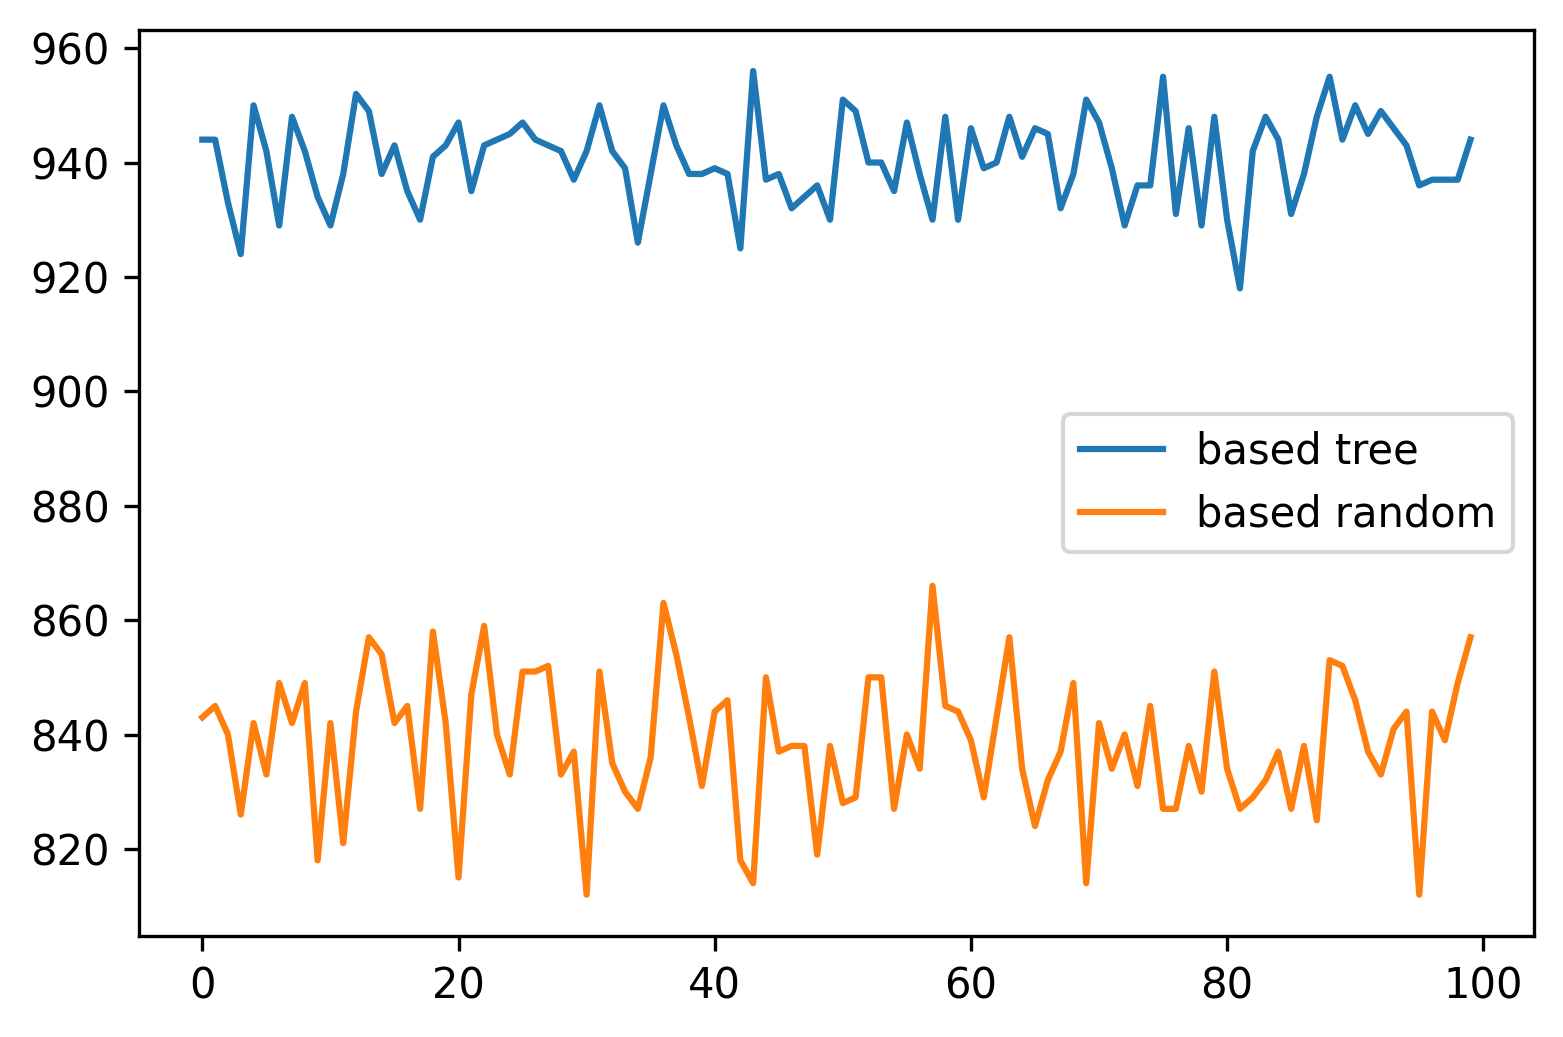

In [15]:
plt.figure(dpi=300)
plt.plot(counter_tree)
plt.plot(counter_random)
plt.legend(['based tree','based random'])

# 快速非支配排序

In [16]:
def compare(p1, p2):
    D = len(p1)
    p1_dominate_p2 = True
    p2_dominate_p1 = True
    for i in range(D):
        if p1[i] > p2[i]:
            p1_dominate_p2 = False
        if p1[i] < p2[i]:
            p2_dominate_p1 = False

    if p1_dominate_p2 == p2_dominate_p1:
        return 0
    return 1 if p1_dominate_p2 else -1

def fast_non_dominated_sort(P):
    P_size = len(P)
    n = np.full(shape=P_size, fill_value=0)
    S = []
    f = []
    rank = np.full(shape=P_size, fill_value=-1)
    f_0 = []
    for p in range(P_size):
        n_p = 0
        S_p = []
        for q in range(P_size):
            if p == q:
                continue
            cmp = compare(P[p], P[q])
            if cmp == 1:
                S_p.append(q)
            elif cmp == -1:
                n_p += 1
        S.append(S_p)
        n[p] = n_p
        if n_p == 0:
            rank[p] = 0
            f_0.append(p)
    f.append(f_0) 
    i = 0
    while len(f[i]) != 0:
        Q = []
        for p in f[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        f.append(Q)
    rank +=1
    return rank,f

# 拥挤度

In [17]:
def tradition_crowd_distance(popf):
    I = popf.shape[0]
    popDistance = np.zeros(shape=(I))
    for M in range(popf.shape[1]):
        popIndex = np.argsort(popf[:,M])
        popDistance[popIndex[0]] = 9999999999999999999999
        popDistance[popIndex[-1]] = 9999999999999999999999
        for i in range(1, I-1):
            popDistance[popIndex[i]] = popDistance[popIndex[i]] + (popf[:,M][popIndex[i+1]] - popf[:,M][popIndex[i-1]])/(popf[:,M][popIndex[-1]] - popf[:,M][popIndex[0]] + 0.000000001)
    return popDistance

In [18]:
def get_first_position(pop, num_part):
    global memory_branch
    global memory_visit
    branch_info = []
    visit_info = []
    for i in range(num_part):
        key_chain = ''.join(str(pop_ele) for pop_ele in pop[:i+1])
        branch_info.append(memory_branch[key_chain])
        visit_info.append(memory_visit[key_chain])
    branch_visit_rate = np.array(branch_info)/(np.array(visit_info)+0.0001)
    return np.random.choice(range(num_part), p = branch_visit_rate/(np.sum(branch_visit_rate)))

In [19]:
def mutation(pop_, constr_mat, num_of_part, direct_constrain):
    pop_c = copy.deepcopy(pop_)
    pop_c = pop_c.tolist()
    mutation_position = np.random.randint(0, num_of_part)
    mutation_part = pop_c[mutation_position]
    pop_c.remove(mutation_part)
    
    if direct_constrain[np.abs(mutation_part)-1]==0 and np.random.uniform()<0.5:
        mutation_part = mutation_part*-1
    
    predecessor_task = (np.argwhere(constr_mat[:,np.abs(mutation_part)-1]==1).reshape(-1)+1).tolist()
    successor_task = (np.argwhere(constr_mat[np.abs(mutation_part)-1,:]==1).reshape(-1)+1).tolist()
    
    if len(predecessor_task)!=0 and len(successor_task)!=0:
        for i in range(len(pop_c)):
            if np.abs(pop_c[i]) in predecessor_task:
                flagFront = i
        for i in range(len(pop_c)):
            if np.abs(pop_c[i]) in successor_task:
                flagBack = i
                break
        pop_c.insert(np.random.choice(range(flagFront+1,flagBack+1)), mutation_part)
    
    elif len(predecessor_task)!=0:
        for i in range(len(pop_c)):
            if np.abs(pop_c[i]) in predecessor_task:
                flagFront = i
        pop_c.insert(np.random.choice(range(flagFront+1,len(pop_c)+1)), mutation_part)
        
    elif len(successor_task)!=0:
        for i in range(len(pop_c)):
            if np.abs(pop_c[i]) in successor_task:
                flagBack = i
                break
        pop_c.insert(np.random.choice(range(0,flagBack+1)), mutation_part)
    
    else:
        pop_c.insert(np.random.choice(range(0,len(pop_c))), mutation_part)
    
    pop_c = np.array(pop_c)
    return pop_c


def crossover(pop1, pop2, num_of_part):
    pop_a = copy.deepcopy(pop1)
    pop_b = copy.deepcopy(pop2)

    start = get_first_position(pop_a, num_of_part)
    end = np.random.choice(range(start, num_of_part))

    piece = []
    for i in range(num_of_part):
        if pop_b[i] in pop_a[start:end+1] or -1*pop_b[i] in pop_a[start:end+1]:
            piece.append(pop_b[i])

    pop_a[start:end+1] = piece
    return pop_a

In [68]:
def make_new_pop(P_, pareto_rank, crowd_dis, crossover_prob, 
                 mutation_prob, num_part, constr_mat, direct_constrain, memory_store):

    global memory_visit
    global memory_branch
    
    P = copy.deepcopy(P_)
    memory_store_list = memory_store.tolist()
    
    popnum = len(P)
    Q = []
    rank = pareto_rank
    crowd_distance = crowd_dis
    for _ in range(int(popnum / 2)):
        i = random.randint(0, popnum - 1)
        j = random.randint(0, popnum - 1)
        while i==j:
            j = random.randint(0, popnum - 1)
        parent1 = P[i]
        parent2 = P[j]
        
        cross_mutation_offspring_1 = parent1
        cross_mutation_offspring_2 = parent2
        if np.random.uniform() < crossover_prob:
            cross_mutation_offspring_1 = crossover(parent1, parent2, num_part)
            cross_mutation_offspring_2 = crossover(parent2, parent1, num_part)
        if np.random.uniform() < mutation_prob:
            cross_mutation_offspring_1 = mutation(cross_mutation_offspring_1, 
                                                  constr_mat, num_part, direct_constrain)
            cross_mutation_offspring_2 = mutation(cross_mutation_offspring_2, 
                                                  constr_mat, num_part, direct_constrain)
        
        Q.append(cross_mutation_offspring_1.tolist())
        Q.append(cross_mutation_offspring_2.tolist())
        
        for offspring_index in range(num_part):
            key_offspring_1_chain = cross_mutation_offspring_1[:offspring_index+1]
            key_offspring_2_chain = cross_mutation_offspring_2[:offspring_index+1]
            visit_dic_key_1 = ''.join(str(pop_ele) for pop_ele in key_offspring_1_chain)
            visit_dic_key_2 = ''.join(str(pop_ele) for pop_ele in key_offspring_2_chain)
            
            if offspring_index == num_part-1:
                if memory_visit.get(visit_dic_key_1) == None and memory_visit.get(visit_dic_key_2) != None:
                    memory_store_list.append(cross_mutation_offspring_1.tolist())
                    for sub_offspring_index in range(num_part):
                        key_offspring_1_chain = cross_mutation_offspring_1[:sub_offspring_index+1]
                        branch_dic_key_1 = ''.join(str(pop_ele) for pop_ele in key_offspring_1_chain)
                        if memory_branch.get(branch_dic_key_1) != None:
                            memory_branch[branch_dic_key_1] += 1
                        else:
                            memory_branch[branch_dic_key_1] = 1
                elif memory_visit.get(visit_dic_key_1) != None and memory_visit.get(visit_dic_key_2) == None:
                    memory_store_list.append(cross_mutation_offspring_2.tolist())
                    for sub_offspring_index in range(num_part):
                        key_offspring_2_chain = cross_mutation_offspring_2[:sub_offspring_index+1]
                        branch_dic_key_2 = ''.join(str(pop_ele) for pop_ele in key_offspring_2_chain)
                        if memory_branch.get(branch_dic_key_2) != None:
                            memory_branch[branch_dic_key_2] += 1
                        else:
                            memory_branch[branch_dic_key_2] = 1
                
                elif memory_visit.get(visit_dic_key_1) == None and memory_visit.get(visit_dic_key_2) == None:
                    if np.all(cross_mutation_offspring_1 == cross_mutation_offspring_2):
                        memory_store_list.append(cross_mutation_offspring_1.tolist())
                        for sub_offspring_index in range(num_part):
                            key_offspring_1_chain = cross_mutation_offspring_1[:sub_offspring_index+1]
                            branch_dic_key_1 = ''.join(str(pop_ele) for pop_ele in key_offspring_1_chain)
                            if memory_branch.get(branch_dic_key_1) != None:
                                memory_branch[branch_dic_key_1] += 1
                            else:
                                memory_branch[branch_dic_key_1] = 1
                    else:
                        memory_store_list.append(cross_mutation_offspring_1.tolist())
                        for sub_offspring_index in range(num_part):
                            key_offspring_1_chain = cross_mutation_offspring_1[:sub_offspring_index+1]
                            branch_dic_key_1 = ''.join(str(pop_ele) for pop_ele in key_offspring_1_chain)
                            if memory_branch.get(branch_dic_key_1) != None:
                                memory_branch[branch_dic_key_1] += 1
                            else:
                                memory_branch[branch_dic_key_1] = 1
                        
                        memory_store_list.append(cross_mutation_offspring_2.tolist())
                        for sub_offspring_index in range(num_part):
                            key_offspring_2_chain = cross_mutation_offspring_2[:sub_offspring_index+1]
                            branch_dic_key_2 = ''.join(str(pop_ele) for pop_ele in key_offspring_2_chain)
                            if memory_branch.get(branch_dic_key_2) != None:
                                memory_branch[branch_dic_key_2] += 1
                            else:
                                memory_branch[branch_dic_key_2] = 1

            if memory_visit.get(visit_dic_key_1) != None:
                memory_visit[visit_dic_key_1] += 1
            else:
                memory_visit[visit_dic_key_1] = 1
            
            
            if memory_visit.get(visit_dic_key_2) != None:
                memory_visit[visit_dic_key_2] += 1
            else:
                memory_visit[visit_dic_key_2] = 1
    return np.array(Q), np.array(memory_store_list)